In [1]:
import torch
import torchvision
import torchaudio 
import os
import torch.nn as nn
from os.path import isfile, join, isdir, exists
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)
np.random.seed(0)

In [2]:
class MusicDataset(Dataset):

    def __init__(self, spec_dir, out_dir, years):
        self.spec_dir = spec_dir
        self.out_dir = out_dir
        self.ims = []
        self.labels = []
        self.names = []

        for dirs in years:
            for f in os.listdir(join(spec_dir, dirs)):
                if(isfile(join(join(out_dir, dirs), f))):
                    self.ims.append(join(join(spec_dir, dirs), f))
                    onm = join(out_dir, dirs)
                    self.labels.append(join(onm, f))
                    self.names.append(join(join(out_dir, dirs), f))
                    #print(join(join(spec_dir, dirs), f))
                    #print(join(onm, f))

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        #print(self.ims[idx])
        
        im, lab = torch.load(self.ims[idx]), torch.load(self.labels[idx])
        if(im.isnan().any()):
            print(self.names[idx])
        mean = torch.mean(im)
        std = torch.std(im)
        if(std==0):
            im = torch.zeros_like(im)
        else:
            im = (im-mean)/(std)

        if(im.isnan().any()):
            print(self.names[idx], "post", mean, std)
            im = torch.zeros_like(im)

        return im, lab

bs = 16
training_data = MusicDataset('mel/', 'mid/', ['2004', '2006', '2008', '2009', '2011', '2013', '2014'])
test_data = MusicDataset('mel/', 'mid/', ['2015', '2017', '2018'])
train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True, )
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=False)

In [3]:
# 229 x 1001 input
# 88 x 7680 output

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.ds1 = dsResConvBlock(1, 16)
        self.ds2 = dsResConvBlock(16, 64)
        self.cnn1 = nn.Conv2d(64, 64, 3, 1, padding='same')
        self.cnn2 = nn.Conv2d(64, 64, 3, 1, padding='same')
        self.us1 = usResConvBlock(64, 16)
        self.us2 = usResConvBlock(32, 4, out_size = (88, 7680))
        self.ReLU = nn.LeakyReLU()
        self.GRU = nn.GRU(input_size = 88*4, hidden_size = 88, num_layers = 2, bidirectional = True, batch_first = True)
        self.Linear = nn.Linear(176, 88)
        

    def forward(self, x):
        y = self.ds1(x)
        res1 = y
        y = self.ds2(y)
        res2 = y
        y = self.cnn1(y)
        y = self.cnn2(y)
        y = self.ReLU(y + res2)
        y = self.us1(y)
        # print(y.shape, res1.shape)
        y = torch.cat((res1, y), axis=1)
        y = self.us2(y)
        
        #print(y.shape)
        output = torch.reshape(y, (y.shape[0], -1, 7680))
        output = torch.swapaxes(output, -1, -2)
        #print(output.shape)
        h0 = torch.zeros(4, y.shape[0], 88).to(output.device)
        output, h0 = self.GRU(output, h0)
        h0.detach()
        output = nn.Sigmoid()(self.Linear(output))
        
        return torch.swapaxes(output, -2, -1)

class dsResConvBlock(nn.Module):
    def __init__(self, num_in, num_out):
        super(dsResConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_in, num_out, (3, 3), (1,1), padding='same')
        self.conv2 = nn.Conv2d(num_out, num_out, (3, 3), (1,1), padding='same')
        self.bn = nn.BatchNorm2d(num_out, momentum=0.9, eps=1e-5)
        self.mp = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.ReLU = nn.LeakyReLU()
    
    def forward(self, x):
        residual = self.ReLU(self.conv1(x))
        y = (self.conv2(residual))
        #y = self.bn(y)
        y = self.ReLU(y + residual)
        y = self.mp(y)
        return y

class usResConvBlock(nn.Module):
    def __init__(self, num_in, num_out, out_size = (1,1)):
        super(usResConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_in, num_out, (3, 3), (1,1), padding='same')
        self.conv2 = nn.Conv2d(num_out, num_out, (3, 3), (1,1), padding='same')
        self.bn = nn.BatchNorm2d(num_out, momentum=0.9, eps=1e-5)
        self.ReLU = nn.LeakyReLU()
        self.out_size = out_size

    def forward(self, x):
        # print("forward 1", x.shape)
        residual = self.ReLU(self.conv1(x))
        y = (self.conv2(residual))
        y = self.ReLU(y + residual)
        # print("forward 2", y.shape)
        if(self.out_size == (1,1)):
            # print("s\n")
            y = nn.Upsample(scale_factor = 2, mode='bilinear')(y)
        else:
            # print("a\n", self.out_size)
            y = nn.Upsample(size = self.out_size, mode='bilinear')(y)
        # print("foward 3")


        return y

def loss_func(x, y):
    # metric = nn.BCELoss()
    # return metric(x.flatten(), (y.flatten()))
    x = torch.clip(x, min=1e-20, max=1-1e-20)
    return torch.mean(y*torch.log(x)*0.75 + (-1*y+1)*torch.log(-1*x+1)*0.25)*-1
    #return torch.mean(y*torch.log(x) + (-1*y+1)*torch.log(-1*x+1))*-1
# a = torch.zeros((5, 5))
# y = torch.ones((5, 5))*0
 
# print(loss_func(a, y))

In [4]:
checkpoint = torch.load('crnn_intermediate_save_3_1_weight2700_0.pt')

model = Model()
model = model.to('cuda')

model.load_state_dict(checkpoint['model_state_dict'])

lr = 3e-4
optim = torch.optim.Adam(lr = lr, params = model.parameters())

optim.load_state_dict(checkpoint['optimizer_state_dict'])
h0 = None
save_epochs = 1
val_print_ep = 5
n_epochs = 100
losses = []
recent = None
for i in range(n_epochs):
    print("starting epoch", i)
    total_loss = 0
    batch = 0
    intlosses = []

    for X, y in train_dataloader:
        #print("batch progress", batch, len(train_dataloader))
        batch += 1
        if(batch % 300 == 0):
            torch.save({
            'epoch': i,
            'batch': batch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': intlosses,
            }, 'crnn_intermediate_save_3_1_weight' + str(batch) + '_' + str(i) + '.pt')
            print(batch, intlosses[-1])
            recent = 'crnn_intermediate_save_3_1_weight' + str(batch) + '_' + str(i) + '.pt'
        X = torch.unsqueeze(X, axis = 1)
        X = X.to('cuda')
        # print(X.shape)
        y = y.type(torch.float32).to('cuda')
        optim.zero_grad()
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_func(pred, y)
        if(torch.isnan(loss)):
            # del model
            # model = Model().to('cuda')
            # checkpoint = torch.load(recent)
            # model.load_state_dict(checkpoint['model_state_dict'])
            # optim.load_state_dict(checkpoint['optimizer_state_dict'])
            # print(pred)
            # print('\n========================================================\n')
            # print(y)
            # print(loss)
            # # print(model.GRU.weight.grad)
            # # print(model.GRU.bias.grad)
            # print(torch.mean(y*torch.log(pred)*0.75))
            # print(torch.mean(-1*(y+1)*torch.log(-1*pred+1)*0.25))
            # print(recent)
            # print(model.us2.weight.grad)
            # print(model.us2.bias.grad)
            continue
        #print(loss.item())
        intlosses.append(loss.item())
        #print(intlosses)
        total_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optim.step()
    losses.append(total_loss)
    print(total_loss)
    if (i % save_epochs == 0):
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses,
            }, 'saved_data.pt')

    if ((i+1) % val_print_ep == 0):
        with torch.no_grad():
            total_loss = 0
            for X, y in test_dataloader:
                X = torch.unsqueeze(X, axis = 1)
                X = X.to('cuda')
                y = y.to('cuda')
                pred = model(X)
                loss = loss_func(y, pred)
                total_loss += loss
        print("Test error after epoch " + str(i) + ": " + str(total_loss/len(test_dataloader)))

starting epoch 0
300 0.01456208061426878
600 0.014766581356525421
900 0.01650547794997692
1200 0.014189956709742546
1500 0.019379712641239166
1800 0.017745565623044968
2100 0.014952878467738628
2400 0.013761774636805058
2700 0.01851653680205345


AttributeError: 'MusicDataset' object has no attribute 'names'

In [ ]:
t = model.GRU.all_weights
for tt in t:
    for ttt in tt:    
        print(torch.max(ttt.grad))
        assert torch.isnan(ttt.view(-1)).sum().item()==0

print(batch)

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
2796


torch.Size([229, 1001])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[1.0209e-04, 3.2739e-05, 1.8241e-05,  ..., 1.9585e-05,
          3.6294e-05, 1.2279e-04],
         [2.9236e-04, 1.2601e-04, 8.2386e-05,  ..., 1.6467e-04,
          2.7748e-04, 7.1921e-04],
         [7.4335e-05, 3.2002e-05, 1.9697e-05,  ..., 1.5785e-04,
          2.7124e-04, 6.6380e-04],
         ...,
         [1.0282e-04, 4.2292e-05, 3.1087e-05,  ..., 2.4661e-05,
          3.8532e-05, 9.1260e-05],
         [1.9922e-04, 8.7194e-05, 6.3790e-05,  ..., 3.6518e-05,
          5.5189e-05, 1.3099e-04],
         [1.0855e-05, 3.8377e-06, 2.6644e-06,  ..., 7.4774e-06,
          1.2946e-05, 3.6679e-05]]]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..

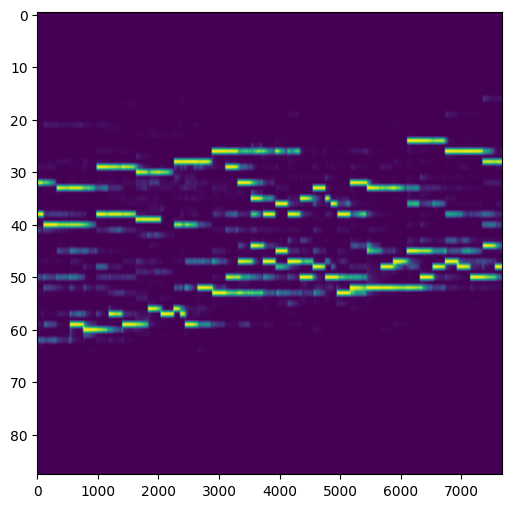

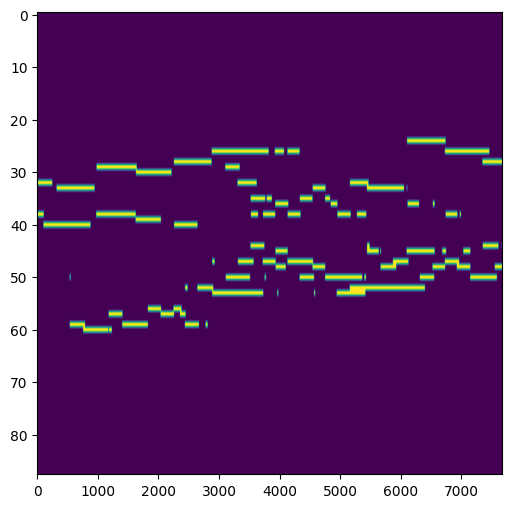

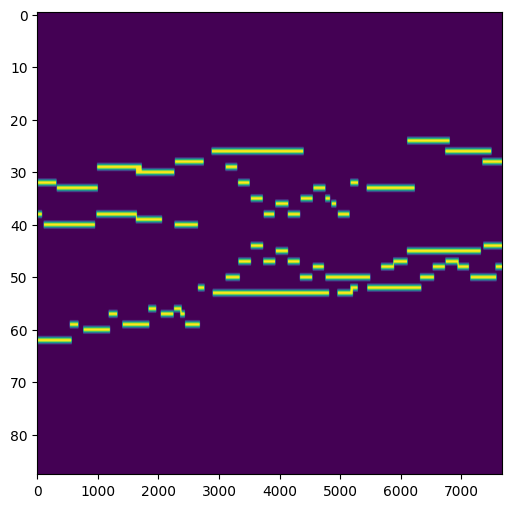

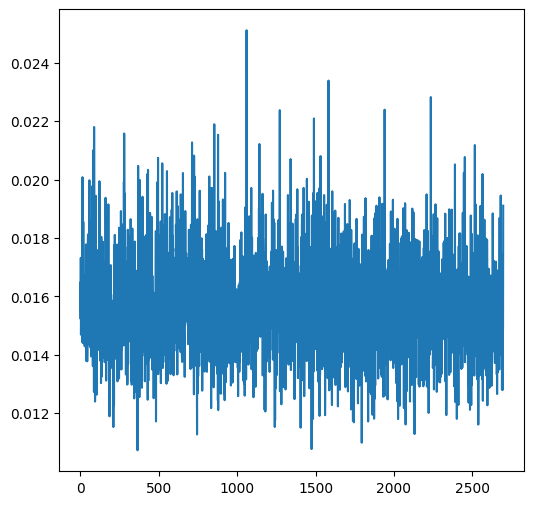

In [ ]:
tt = DataLoader(test_data, batch_size=1, shuffle=False)
meval = Model().to('cuda')
checkpoint = torch.load('crnn_intermediate_save_3_1_weight2700_0.pt')
meval.load_state_dict(checkpoint['model_state_dict'])
meval.train()
fname = "mel/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
X = torch.load(fname)
print(X.shape)
fname = "mid/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
y = torch.load(fname).type(torch.float32)
X = torch.unsqueeze(X, axis = 0)
X = torch.unsqueeze(X, axis = 0)
# X = X.to('cuda')
# y = y.to('cuda')
# print(nn.CrossEntropyLoss()(y, pred[0, :, :]))

with torch.no_grad():    
    pred = meval(X.to('cuda')).to('cpu')
    #print(nn.BCELoss()(pred[0, :, :], y))

print(np.round(pred.to('cpu')))

print(pred, y)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(pred[0, :, :], aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.round(pred[0, :, :]), aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(y, aspect='auto')
# print(y.shape, pred.shape)
fig, ax = plt.subplots(figsize=(6,6))   
ax.plot(checkpoint['loss'])
print(torch.max(pred))